In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
from PIL import Image
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torchvision 
from torchvision import models, transforms
 

from torch.utils.data import Dataset, DataLoader


In [2]:
project_dir     = '/Users/kaheichoi/git_repo/csiro_biomass'
data_dir        = os.path.join(project_dir, 'data')
train_df        = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [3]:
def data_preprocess(df, target_names = ['Dry_Clover_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Total_g', 'GDM_g']):
    data= []
    unique_path = df['image_path'].unique()
    print(f"number of unique path: {unique_path.shape}")

    for img_path in unique_path:
        path_data = df[df['image_path']==img_path]
        row       = {'img_path': img_path}

        for tar in target_names:
            target_row = path_data[ path_data['target_name'] == tar ]
            if len(target_row)>0:
                row[tar] = target_row['target'].values[0]
            else:
                row[tar] = 0

        data.append(row)

    return pd.DataFrame(data)

data = data_preprocess(train_df)
data.info()
display(data.head())

assert data['img_path'].duplicated().sum() == 0

number of unique path: (357,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img_path      357 non-null    object 
 1   Dry_Clover_g  357 non-null    float64
 2   Dry_Green_g   357 non-null    float64
 3   Dry_Dead_g    357 non-null    float64
 4   Dry_Total_g   357 non-null    float64
 5   GDM_g         357 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.9+ KB


,img_path,Dry_Clover_g,Dry_Green_g,Dry_Dead_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,16.2751,31.9984,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,7.6000,0.0000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,24.2376,30.9703,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,10.5261,23.2239,34.1844,10.9605


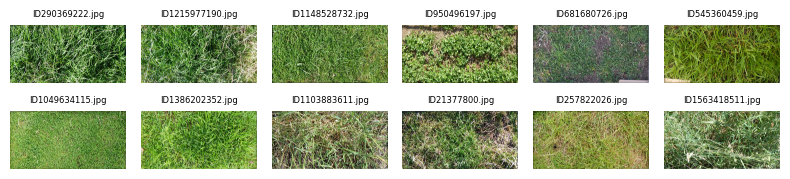

In [4]:
fig, axes = plt.subplots(2, 6, figsize=(8, 2)); axes = axes.flatten()

rand_sample = np.random.choice(len(data), 32, replace=False)

for i , ax in enumerate(axes): 
    img = Image.open(  os.path.join(data_dir, data.iloc[rand_sample[i]]['img_path']) )
    ax.imshow(img)
    ax.set_title(data.iloc[rand_sample[i]]['img_path'].split('/')[-1],fontsize = 6)
    ax.axis('off')

plt.tight_layout();plt.show()

In [5]:
train_data , valid_data = train_test_split(data, test_size=0.2, random_state=8964)
train_data , test_data  = train_test_split(train_data, test_size=0.1, random_state=8964)

In [6]:
def compute_img_mean_std(df, data_dir):

    means = np.zeros(3)
    stds = np.zeros(3)
    counts = 0

    for img_id in tqdm(df['img_path'], desc = 'Calculating mean and std'):
        img = Image.open(os.path.join(data_dir, img_id))
        img = img.convert('RGB')
        arr = np.array(img)/255.0

        arr = arr.reshape(-1,3)

        means += arr.mean(axis=0)
        stds += arr.std(axis=0)

        counts +=1 

    mean_val = means/counts ;print(mean_val)
    std_val = stds/counts ;print(std_val)

    return mean_val, std_val


resnet50_pretrained = True

if resnet50_pretrained:
    mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
else:
    mean, std = compute_img_mean_std(train_data, data_dir)
    assert mean.shape == (3,) and std.shape == (3,) and mean.all() > 0 and std.all() > 0

print(f"mean: {mean}, std: {std}")

mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    # torchvision.transforms.GaussianBlur(1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [8]:
class BiomassDS(Dataset):

    def __init__(self, df, transform, data_dir, target_names = ['Dry_Clover_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Total_g', 'GDM_g']):

        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['img_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        targets = torch.tensor( [ row[tar] for tar in self.target_names ], dtype=torch.float32)

        return img, targets

train_ds = BiomassDS(df= train_data, transform= train_transform, data_dir= data_dir); print(f"train_ds length: {len(train_ds)}")
valid_ds = BiomassDS(df= valid_data, transform= valid_transform, data_dir= data_dir); print(f"valid_ds length: {len(valid_ds)}")

sample_img, sample_target = train_ds[0]
assert sample_img.shape == torch.Size([3, 224, 224]) and sample_target.shape == torch.Size([5])

sample_img, sample_target = valid_ds[0]
assert sample_img.shape == torch.Size([3, 224, 224]) and sample_target.shape == torch.Size([5])



train_ds length: 256
valid_ds length: 72


In [9]:
batch_size = 16
slaves = 0

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=slaves, pin_memory=False); print(f"train_loader length: {len(train_loader)}")
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=slaves, pin_memory=False); print(f"valid_loader length: {len(valid_loader)}")

for imgs,tars in train_loader:
    assert imgs.shape == torch.Size([batch_size, 3, 224, 224]) and tars.shape == torch.Size([batch_size, 5])
    break

for imgs,tars in valid_loader:
    assert imgs.shape == torch.Size([batch_size, 3, 224, 224]) and tars.shape == torch.Size([batch_size, 5])
    break

train_loader length: 16
valid_loader length: 5


In [10]:
class get_baselineCNN(nn.Module):

    def __init__(self, n_outputs = 5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.regressor(x)
        return x


class get_resnet50(nn.Module):

    def __init__(self, n_outputs = 5):
        super().__init__()
 
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT )
        for param in self.backbone.parameters():
            param.requires_grad = False
 
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, n_outputs)

    def forward(self, x):
        return self.backbone(x)

In [11]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# model = get_baselineCNN().to(device)
model = get_resnet50().to(device)

x = torch.randn(16, 3, 224, 224).to(device)
y = model(x); assert y.shape == torch.Size([16, 5])

In [16]:
learning_rate = 1e-2
num_epochs = 100
weight_decay = 1e-4
patience = 13

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
criteron  = nn.MSELoss()

In [17]:
from sklearn.metrics import mean_squared_error

history =  {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'learning_rate': []}
best_val = float('inf')
epoch_counter = 0
model_dir = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)
ii = 0

for epoch in range(num_epochs):

    """ training """
    model.train()
    train_loss = 0
    n_train = 0

    pbar = tqdm(train_loader, desc = f"Epoch {epoch+1}/{num_epochs} training")
    for imgs, tars in pbar:
        imgs, tars = imgs.to(device), tars.to(device)
        
        optimizer.zero_grad()
        preds = model(imgs)

        loss  = criteron(preds, tars)
        
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        train_loss += loss.item() * batch_size
        n_train += batch_size 

    train_loss = train_loss / n_train

    """ validation """
    valid_loss = 0
    n_valid = 0
    pred_list, targ_list = [], []

    model.eval()
    with torch.no_grad():
        pbar = tqdm(valid_loader, desc = f"Epoch {epoch+1}/{num_epochs} validation")
        for imgs, tars in pbar:
            imgs, tars = imgs.to(device), tars.to(device)

            preds = model(imgs)
            loss = criteron(preds, tars)

            batch_size = imgs.size(0)
            valid_loss += loss.item() * batch_size
            n_valid += batch_size

            pred_list.append(preds.cpu())
            targ_list.append(tars.cpu())

    valid_loss = valid_loss / n_valid

    """ evaluate mse """
    all_preds = torch.cat(pred_list, dim=0).numpy()
    all_targs = torch.cat(targ_list, dim=0).numpy()

    mse = mean_squared_error(all_targs, all_preds)
    rmser = np.sqrt(mse) 

    """ update learning rate """
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmser)
    history['learning_rate'].append(current_lr)


    print(f"train loss: {train_loss:.4f}")
    print(f"valid loss: {valid_loss:.4f}")
    print(f"rmse: {rmser:.4f}")
    print(f"mse: {mse:.4f}")
    print(f"lr: {current_lr:.6f}")
    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    print(f"per target rmse: {per_target_rmse}")

    ii += 1

    """ save best model """
    if valid_loss < best_val:
        print(f"valid loss improved from: {best_val:.4f} to {valid_loss:.4f} with rmse: {rmser:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"valid loss did not improve from: {best_val:.4f}")

    """ early stopping """
    if epoch_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch 1/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 317.1914
valid loss: 287.7996
rmse: 16.9647
mse: 287.7995
lr: 0.010000
per target rmse: [ 7.1997695 17.52723   13.3310995 23.5599    18.632502 ]
valid loss improved from: inf to 287.7996 with rmse: 16.9647
best model saved


Epoch 2/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 281.5442
valid loss: 293.5401
rmse: 17.1330
mse: 293.5401
lr: 0.010000
per target rmse: [ 7.1229634 17.565475  13.523805  23.898842  18.824718 ]
valid loss did not improve from: 287.7996


Epoch 3/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 285.7992
valid loss: 282.3004
rmse: 16.8018
mse: 282.3004
lr: 0.010000
per target rmse: [ 7.537752 17.076237 13.832377 23.089128 18.40228 ]
valid loss improved from: 287.7996 to 282.3004 with rmse: 16.8018
best model saved


Epoch 4/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 253.2739
valid loss: 287.5498
rmse: 16.9573
mse: 287.5497
lr: 0.010000
per target rmse: [ 6.9336925 17.474073  13.584921  23.470308  18.6795   ]
valid loss did not improve from: 282.3004


Epoch 5/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 281.8445
valid loss: 287.9113
rmse: 16.9679
mse: 287.9113
lr: 0.010000
per target rmse: [ 6.9062057 17.305227  13.471025  23.557253  18.867357 ]
valid loss did not improve from: 282.3004


Epoch 6/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 291.6672
valid loss: 290.2251
rmse: 17.0360
mse: 290.2251
lr: 0.010000
per target rmse: [ 7.0147433 17.611004  14.165042  23.328037  18.62594  ]
valid loss did not improve from: 282.3004


Epoch 7/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 281.7436
valid loss: 282.1650
rmse: 16.7978
mse: 282.1649
lr: 0.010000
per target rmse: [ 7.1071625 17.067793  14.1327095 23.051514  18.381996 ]
valid loss improved from: 282.3004 to 282.1650 with rmse: 16.7978
best model saved


Epoch 8/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 287.0786
valid loss: 270.2412
rmse: 16.4390
mse: 270.2412
lr: 0.010000
per target rmse: [ 7.2042685 16.812319  13.505707  22.634153  17.942726 ]
valid loss improved from: 282.1650 to 270.2412 with rmse: 16.4390
best model saved


Epoch 9/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 292.5608
valid loss: 271.2129
rmse: 16.4685
mse: 271.2129
lr: 0.010000
per target rmse: [ 6.957888 16.710293 13.719324 22.875942 17.801397]
valid loss did not improve from: 270.2412


Epoch 10/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 291.6923
valid loss: 279.4352
rmse: 16.7163
mse: 279.4351
lr: 0.010000
per target rmse: [ 7.418813 17.125128 13.38999  23.125921 18.296635]
valid loss did not improve from: 270.2412


Epoch 11/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 287.2298
valid loss: 272.7329
rmse: 16.5146
mse: 272.7330
lr: 0.010000
per target rmse: [ 6.978976 16.83551  13.417959 23.048315 17.89575 ]
valid loss did not improve from: 270.2412


Epoch 12/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 270.5604
valid loss: 273.5389
rmse: 16.5390
mse: 273.5389
lr: 0.010000
per target rmse: [ 6.866476  16.695559  14.2865505 22.813833  17.810888 ]
valid loss did not improve from: 270.2412


Epoch 13/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 280.6524
valid loss: 278.1050
rmse: 16.6765
mse: 278.1050
lr: 0.010000
per target rmse: [ 6.9661694 16.826889  14.120938  23.273586  17.826742 ]
valid loss did not improve from: 270.2412


Epoch 14/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 268.4236
valid loss: 273.9915
rmse: 16.5527
mse: 273.9915
lr: 0.005000
per target rmse: [ 6.881384 17.049189 13.707374 22.825264 17.973442]
valid loss did not improve from: 270.2412


Epoch 15/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 237.0686
valid loss: 273.3049
rmse: 16.5319
mse: 273.3049
lr: 0.005000
per target rmse: [ 6.710168 16.847355 13.715387 23.07839  17.802828]
valid loss did not improve from: 270.2412


Epoch 16/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 271.3586
valid loss: 270.5935
rmse: 16.4497
mse: 270.5934
lr: 0.005000
per target rmse: [ 6.8813405 16.724854  13.482994  22.953207  17.811596 ]
valid loss did not improve from: 270.2412


Epoch 17/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 257.3933
valid loss: 266.3786
rmse: 16.3211
mse: 266.3786
lr: 0.005000
per target rmse: [ 6.822798 16.552483 13.664209 22.674831 17.62098 ]
valid loss improved from: 270.2412 to 266.3786 with rmse: 16.3211
best model saved


Epoch 18/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 267.8374
valid loss: 265.9390
rmse: 16.3076
mse: 265.9390
lr: 0.005000
per target rmse: [ 6.7991004 16.50152   13.645135  22.702322  17.594942 ]
valid loss improved from: 266.3786 to 265.9390 with rmse: 16.3076
best model saved


Epoch 19/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 251.8499
valid loss: 268.0247
rmse: 16.3715
mse: 268.0248
lr: 0.005000
per target rmse: [ 6.8473744 16.706903  13.54393   22.699583  17.759718 ]
valid loss did not improve from: 265.9390


Epoch 20/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 247.5934
valid loss: 269.5245
rmse: 16.4172
mse: 269.5245
lr: 0.005000
per target rmse: [ 6.780163  16.764864  13.7636595 22.798584  17.645891 ]
valid loss did not improve from: 265.9390


Epoch 21/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 251.0315
valid loss: 271.8562
rmse: 16.4881
mse: 271.8562
lr: 0.005000
per target rmse: [ 6.865484 16.901455 13.735417 22.670242 17.99682 ]
valid loss did not improve from: 265.9390


Epoch 22/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 229.2422
valid loss: 270.6337
rmse: 16.4510
mse: 270.6338
lr: 0.005000
per target rmse: [ 6.9480805 16.700909  13.419777  22.824387  18.025803 ]
valid loss did not improve from: 265.9390


Epoch 23/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


train loss: 236.2617
valid loss: 267.1520
rmse: 16.3448
mse: 267.1519
lr: 0.005000
per target rmse: [ 6.9406447 16.688353  13.722792  22.407187  17.851868 ]
valid loss did not improve from: 265.9390


Epoch 24/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 233.6723
valid loss: 268.3144
rmse: 16.3803
mse: 268.3144
lr: 0.002500
per target rmse: [ 6.9128733 16.840212  13.464933  22.230053  18.295128 ]
valid loss did not improve from: 265.9390


Epoch 25/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 242.8492
valid loss: 267.0986
rmse: 16.3432
mse: 267.0986
lr: 0.002500
per target rmse: [ 6.833371 16.620224 13.543471 22.631012 17.803867]
valid loss did not improve from: 265.9390


Epoch 26/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 254.4097
valid loss: 264.1216
rmse: 16.2518
mse: 264.1216
lr: 0.002500
per target rmse: [ 6.69496  16.526552 13.617111 22.460487 17.685001]
valid loss improved from: 265.9390 to 264.1216 with rmse: 16.2518
best model saved


Epoch 27/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 253.9701
valid loss: 264.4105
rmse: 16.2607
mse: 264.4105
lr: 0.002500
per target rmse: [ 6.828205 16.49364  13.715569 22.415333 17.686832]
valid loss did not improve from: 264.1216


Epoch 28/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 251.8835
valid loss: 267.9563
rmse: 16.3694
mse: 267.9563
lr: 0.002500
per target rmse: [ 6.833467 16.836246 13.432174 22.549347 17.90893 ]
valid loss did not improve from: 264.1216


Epoch 29/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 235.5715
valid loss: 265.8134
rmse: 16.3038
mse: 265.8134
lr: 0.002500
per target rmse: [ 6.9464555 16.550072  13.519493  22.554855  17.7598   ]
valid loss did not improve from: 264.1216


Epoch 30/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 253.0387
valid loss: 263.5529
rmse: 16.2343
mse: 263.5529
lr: 0.002500
per target rmse: [ 6.946499 16.508736 13.491422 22.464132 17.615812]
valid loss improved from: 264.1216 to 263.5529 with rmse: 16.2343
best model saved


Epoch 31/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 236.3153
valid loss: 260.3008
rmse: 16.1338
mse: 260.3008
lr: 0.002500
per target rmse: [ 6.913609 16.22682  13.713075 22.328209 17.429829]
valid loss improved from: 263.5529 to 260.3008 with rmse: 16.1338
best model saved


Epoch 32/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


train loss: 240.8796
valid loss: 262.6120
rmse: 16.2053
mse: 262.6120
lr: 0.002500
per target rmse: [ 6.910147 16.585615 13.568968 22.113478 17.807425]
valid loss did not improve from: 260.3008


Epoch 33/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 246.4339
valid loss: 265.1629
rmse: 16.2838
mse: 265.1629
lr: 0.002500
per target rmse: [ 6.9971733 16.57983   13.622007  22.289312  17.877098 ]
valid loss did not improve from: 260.3008


Epoch 34/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 251.3862
valid loss: 262.2621
rmse: 16.1945
mse: 262.2621
lr: 0.002500
per target rmse: [ 6.9025016 16.348484  13.58236   22.356918  17.665813 ]
valid loss did not improve from: 260.3008


Epoch 35/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 244.1077
valid loss: 264.9625
rmse: 16.2777
mse: 264.9625
lr: 0.002500
per target rmse: [ 6.90363  16.6088   13.716986 22.233894 17.854929]
valid loss did not improve from: 260.3008


Epoch 36/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 261.7873
valid loss: 261.2556
rmse: 16.1634
mse: 261.2556
lr: 0.002500
per target rmse: [ 6.740382 16.416723 13.529318 22.494738 17.386217]
valid loss did not improve from: 260.3008


Epoch 37/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 239.3916
valid loss: 260.4296
rmse: 16.1378
mse: 260.4296
lr: 0.001250
per target rmse: [ 6.8014746 16.52559   13.463678  22.076206  17.724651 ]
valid loss did not improve from: 260.3008


Epoch 38/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 239.9204
valid loss: 261.6793
rmse: 16.1765
mse: 261.6793
lr: 0.001250
per target rmse: [ 6.734378 16.559288 13.458635 22.2626   17.665678]
valid loss did not improve from: 260.3008


Epoch 39/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 248.8475
valid loss: 260.8556
rmse: 16.1510
mse: 260.8556
lr: 0.001250
per target rmse: [ 6.6080623 16.437511  13.498272  22.33579   17.587746 ]
valid loss did not improve from: 260.3008


Epoch 40/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 249.4653
valid loss: 262.9216
rmse: 16.2149
mse: 262.9216
lr: 0.001250
per target rmse: [ 6.9339542 16.464628  13.797792  22.260584  17.593506 ]
valid loss did not improve from: 260.3008


Epoch 41/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 252.8024
valid loss: 259.8830
rmse: 16.1209
mse: 259.8830
lr: 0.001250
per target rmse: [ 6.74528  16.399368 13.50162  22.327538 17.440302]
valid loss improved from: 260.3008 to 259.8830 with rmse: 16.1209
best model saved


Epoch 42/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 229.8296
valid loss: 256.3401
rmse: 16.0106
mse: 256.3400
lr: 0.001250
per target rmse: [ 6.6571665 16.434113  13.532704  21.93821   17.403536 ]
valid loss improved from: 259.8830 to 256.3401 with rmse: 16.0106
best model saved


Epoch 43/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 236.9778
valid loss: 258.9061
rmse: 16.0906
mse: 258.9061
lr: 0.001250
per target rmse: [ 6.810265 16.278975 13.634851 22.388979 17.203785]
valid loss did not improve from: 256.3401


Epoch 44/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 274.2380
valid loss: 264.4756
rmse: 16.2627
mse: 264.4757
lr: 0.001250
per target rmse: [ 6.8360257 16.698032  13.425031  22.235989  17.9486   ]
valid loss did not improve from: 256.3401


Epoch 45/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train loss: 232.3238
valid loss: 261.2881
rmse: 16.1644
mse: 261.2881
lr: 0.001250
per target rmse: [ 6.8417645 16.532787  13.37318   22.347404  17.551336 ]
valid loss did not improve from: 256.3401


Epoch 46/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


train loss: 229.4282
valid loss: 259.7105
rmse: 16.1155
mse: 259.7105
lr: 0.001250
per target rmse: [ 6.818265 16.218876 13.451459 22.451593 17.435486]
valid loss did not improve from: 256.3401


Epoch 47/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 243.8633
valid loss: 258.2628
rmse: 16.0706
mse: 258.2628
lr: 0.001250
per target rmse: [ 6.7093396 16.30307   13.546114  22.248968  17.377996 ]
valid loss did not improve from: 256.3401


Epoch 48/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 257.8739
valid loss: 261.6172
rmse: 16.1746
mse: 261.6172
lr: 0.000625
per target rmse: [ 6.8726296 16.36793   13.447055  22.386343  17.6344   ]
valid loss did not improve from: 256.3401


Epoch 49/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 225.5983
valid loss: 261.6675
rmse: 16.1761
mse: 261.6675
lr: 0.000625
per target rmse: [ 6.7344556 16.360155  13.522887  22.523277  17.46893  ]
valid loss did not improve from: 256.3401


Epoch 50/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 234.1965
valid loss: 254.2424
rmse: 15.9450
mse: 254.2424
lr: 0.000625
per target rmse: [ 6.793309 16.077606 13.5274   22.0369   17.261461]
valid loss improved from: 256.3401 to 254.2424 with rmse: 15.9450
best model saved


Epoch 51/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 280.0656
valid loss: 258.1185
rmse: 16.0661
mse: 258.1185
lr: 0.000625
per target rmse: [ 6.730573 16.271189 13.505017 22.221733 17.445614]
valid loss did not improve from: 254.2424


Epoch 52/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 244.0998
valid loss: 259.9093
rmse: 16.1217
mse: 259.9093
lr: 0.000625
per target rmse: [ 6.7375746 16.366566  13.4859705 22.410975  17.38286  ]
valid loss did not improve from: 254.2424


Epoch 53/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


train loss: 223.3960
valid loss: 260.6688
rmse: 16.1452
mse: 260.6687
lr: 0.000625
per target rmse: [ 6.678078 16.500029 13.542364 22.277998 17.515453]
valid loss did not improve from: 254.2424


Epoch 54/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 257.8089
valid loss: 263.9961
rmse: 16.2480
mse: 263.9961
lr: 0.000625
per target rmse: [ 6.7508492 16.446203  13.514606  22.74605   17.43277  ]
valid loss did not improve from: 254.2424


Epoch 55/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 239.6880
valid loss: 264.0956
rmse: 16.2510
mse: 264.0956
lr: 0.000625
per target rmse: [ 6.810419 16.44189  13.438548 22.67956  17.572807]
valid loss did not improve from: 254.2424


Epoch 56/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 225.0752
valid loss: 252.4144
rmse: 15.8876
mse: 252.4144
lr: 0.000625
per target rmse: [ 6.73941  15.990975 13.575862 22.04501  17.048592]
valid loss improved from: 254.2424 to 252.4144 with rmse: 15.8876
best model saved


Epoch 57/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 261.2128
valid loss: 261.7249
rmse: 16.1779
mse: 261.7249
lr: 0.000625
per target rmse: [ 6.829051 16.42421  13.493394 22.453888 17.492428]
valid loss did not improve from: 252.4144


Epoch 58/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 253.3665
valid loss: 259.1428
rmse: 16.0979
mse: 259.1428
lr: 0.000625
per target rmse: [ 6.860197 16.298616 13.55544  22.132502 17.590027]
valid loss did not improve from: 252.4144


Epoch 59/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 237.4948
valid loss: 265.3362
rmse: 16.2891
mse: 265.3362
lr: 0.000625
per target rmse: [ 6.6839857 16.529741  13.483273  22.689194  17.668474 ]
valid loss did not improve from: 252.4144


Epoch 60/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 234.3475
valid loss: 263.0473
rmse: 16.2187
mse: 263.0473
lr: 0.000625
per target rmse: [ 6.726018 16.334568 13.437607 22.6966   17.534943]
valid loss did not improve from: 252.4144


Epoch 61/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 237.9505
valid loss: 258.0460
rmse: 16.0638
mse: 258.0460
lr: 0.000625
per target rmse: [ 6.7791677 16.170935  13.364982  22.458393  17.313913 ]
valid loss did not improve from: 252.4144


Epoch 62/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


train loss: 259.6203
valid loss: 260.3838
rmse: 16.1364
mse: 260.3837
lr: 0.000313
per target rmse: [ 6.8300753 16.202585  13.459035  22.586432  17.362387 ]
valid loss did not improve from: 252.4144


Epoch 63/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 244.3686
valid loss: 257.9485
rmse: 16.0608
mse: 257.9485
lr: 0.000313
per target rmse: [ 6.7904825 16.310598  13.578223  22.15685   17.386835 ]
valid loss did not improve from: 252.4144


Epoch 64/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 243.2034
valid loss: 257.3630
rmse: 16.0425
mse: 257.3630
lr: 0.000313
per target rmse: [ 6.8803544 16.402613  13.590163  21.994837  17.37713  ]
valid loss did not improve from: 252.4144


Epoch 65/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 248.5074
valid loss: 262.6223
rmse: 16.2056
mse: 262.6223
lr: 0.000313
per target rmse: [ 6.702317 16.528143 13.572485 22.412582 17.563452]
valid loss did not improve from: 252.4144


Epoch 66/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 245.5114
valid loss: 264.7044
rmse: 16.2697
mse: 264.7044
lr: 0.000313
per target rmse: [ 6.8140664 16.47481   13.488337  22.629784  17.653015 ]
valid loss did not improve from: 252.4144


Epoch 67/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 247.2503
valid loss: 258.5909
rmse: 16.0808
mse: 258.5909
lr: 0.000313
per target rmse: [ 6.716099 16.24597  13.438159 22.405268 17.359055]
valid loss did not improve from: 252.4144


Epoch 68/100 validation: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train loss: 231.0379
valid loss: 255.7099
rmse: 15.9909
mse: 255.7099
lr: 0.000156
per target rmse: [ 6.8337   16.134613 13.353421 22.20079  17.330181]
valid loss did not improve from: 252.4144


Epoch 69/100 validation: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

train loss: 234.9498
valid loss: 263.9092
rmse: 16.2453
mse: 263.9092
lr: 0.000156
per target rmse: [ 6.8935356 16.43779   13.458662  22.541693  17.679382 ]
valid loss did not improve from: 252.4144
Early stopping at epoch 69


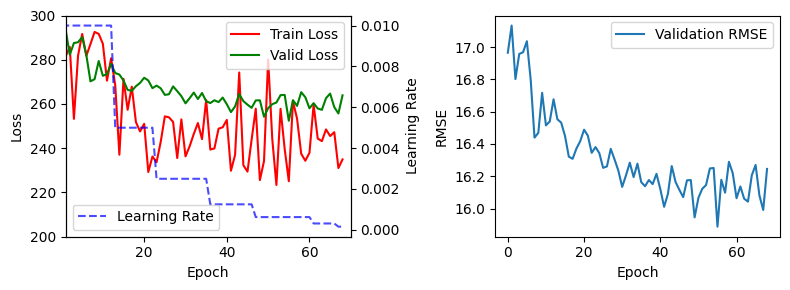

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(1, 70)
axes[0].set_ylim(200, 300)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()


In [171]:
data.describe()

,Dry_Clover_g,Dry_Green_g,Dry_Dead_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,26.624722,12.044548,45.318097,33.274414
std,12.117761,25.401232,12.402007,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,8.800000,3.200000,25.271500,16.026100
50%,1.423500,20.800000,7.980900,40.300000,27.108200
75%,7.242900,35.083400,17.637800,57.880000,43.675700
max,71.786500,157.983600,83.840700,185.700000,157.983600


In [ ]:
per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
print(per_target_rmse)

[ 8.689291 34.754436 14.646674 28.963827 30.987223]
